In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


---------------------------------------------------------------------------------------------------------------------------

#### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [2]:
query1 = '''
select f.film_id,count(r.rental_id) as f_total_rentals,f.rating,f.replacement_cost, MONTH(r.rental_date) as rental_month, 
YEAR(rental_date) as rental_year
from film f
inner join inventory i
on f.film_id=i.film_id
inner join rental r
on r.inventory_id=i.inventory_id
where rental_date like '2006%%'
group by f.film_id
order by f.film_id;'''

In [3]:
query2 = '''
select f.film_id,count(r.rental_id) as f_total_rentals,f.rating,f.replacement_cost, MONTH(r.rental_date) as rental_month, 
YEAR(rental_date) as rental_year
from film f
inner join inventory i
on f.film_id=i.film_id
inner join rental r
on r.inventory_id=i.inventory_id
where rental_date like '2005%%'
group by f.film_id
order by f.film_id;'''

---------------------------------------------------------------------------------------------------------------------------

#### 2. Read the data into a Pandas dataframe.

In [4]:
data1 = pd.read_sql_query(query1, engine)
data1.head()

,film_id,f_total_rentals,rating,replacement_cost,rental_month,rental_year
0,2,1,G,12.99,2,2006
1,4,1,G,26.99,2,2006
2,5,1,G,22.99,2,2006
3,13,1,PG,21.99,2,2006
4,17,1,R,14.99,2,2006


In [5]:
data1.shape

(168, 6)

In [6]:
data2 = pd.read_sql_query(query2, engine)
data2.head()

,film_id,f_total_rentals,rating,replacement_cost,rental_month,rental_year
0,1,23,PG,20.99,5,2005
1,2,6,G,12.99,7,2005
2,3,12,NC-17,18.99,5,2005
3,4,22,G,26.99,5,2005
4,5,11,G,22.99,5,2005


In [7]:
data2.shape

(958, 6)

 - **Concating the dataframes to get the final data frame**

In [32]:
data = pd.concat([data1, data2], ignore_index=True)
data.head()

,film_id,f_total_rentals,rating,replacement_cost,rental_month,rental_year
0,2,1,G,12.99,2,2006
1,4,1,G,26.99,2,2006
2,5,1,G,22.99,2,2006
3,13,1,PG,21.99,2,2006
4,17,1,R,14.99,2,2006


In [33]:
data.shape

(1126, 6)

In [34]:
# shuffle the DataFrame rows
data = data.sample(frac=1).reset_index(drop=True)

# Here, specifying drop=True prevents .reset_index from creating a column containing the old index entries.

In [35]:
data.head()

,film_id,f_total_rentals,rating,replacement_cost,rental_month,rental_year
0,475,6,G,29.99,6,2005
1,120,9,NC-17,16.99,5,2005
2,856,25,R,11.99,5,2005
3,982,1,R,23.99,2,2006
4,303,26,PG-13,27.99,5,2005


###### Another way to shuffle data using sklearn 

 - from sklearn.utils import shuffle
 - data = shuffle(data)
 
**The above shuffling will not reset the index. so we need to reset indexes after shuffling**
 - data.reset_index(inplace=True, drop=True)

---------------------------------------------------------------------------------------------------------------------------

##### Exploring the data

In [36]:
data.shape

(1126, 6)

 - We are having **1126 rows** and **6 columns**

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1126 non-null   int64  
 1   f_total_rentals   1126 non-null   int64  
 2   rating            1126 non-null   object 
 3   replacement_cost  1126 non-null   float64
 4   rental_month      1126 non-null   int64  
 5   rental_year       1126 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 52.9+ KB


 - There are **no null values** in dataframe as we did **inner joins**

In [38]:
data.rating.value_counts()

PG-13    251
NC-17    240
PG       217
R        215
G        203
Name: rating, dtype: int64

##### EDA

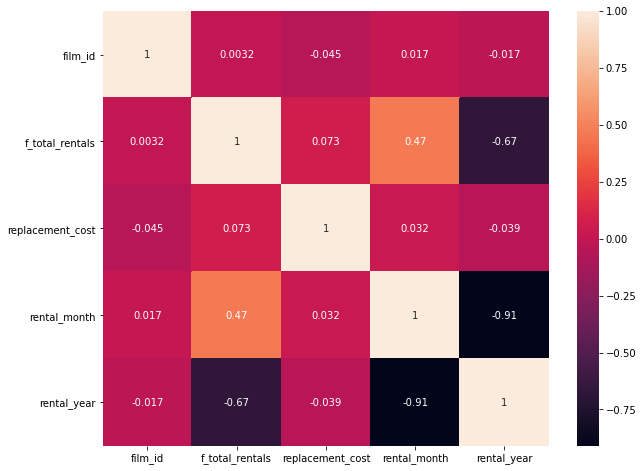

In [39]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [40]:
data.columns

Index(['film_id', 'f_total_rentals', 'rating', 'replacement_cost',
       'rental_month', 'rental_year'],
      dtype='object')

#### 3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [41]:
data.head()

,film_id,f_total_rentals,rating,replacement_cost,rental_month,rental_year
0,475,6,G,29.99,6,2005
1,120,9,NC-17,16.99,5,2005
2,856,25,R,11.99,5,2005
3,982,1,R,23.99,2,2006
4,303,26,PG-13,27.99,5,2005


In [42]:
# Writing a function to set the target column

def f(data):
    if data['rental_month'] == 2:
        val = 1
    else:
        val = 0
    return val

In [43]:
data['target'] = data.apply(f, axis=1)

In [44]:
data.head(100)

,film_id,f_total_rentals,rating,replacement_cost,rental_month,rental_year,target
0,475,6,G,29.99,6,2005,0
1,120,9,NC-17,16.99,5,2005,0
2,856,25,R,11.99,5,2005,0
3,982,1,R,23.99,2,2006,1
4,303,26,PG-13,27.99,5,2005,0
...,...,...,...,...,...,...,...
95,396,19,G,18.99,5,2005,0
96,109,30,G,17.99,5,2005,0
97,255,21,NC-17,21.99,5,2005,0
98,220,28,NC-17,13.99,5,2005,0


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1126 non-null   int64  
 1   f_total_rentals   1126 non-null   int64  
 2   rating            1126 non-null   object 
 3   replacement_cost  1126 non-null   float64
 4   rental_month      1126 non-null   int64  
 5   rental_year       1126 non-null   int64  
 6   target            1126 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 61.7+ KB


In [46]:
# Normalizing the data
num = data.select_dtypes(include = np.number)
num = num.drop(['target','rental_month','rental_year'], axis=1)

transformer = StandardScaler().fit(num)
num_normalized = transformer.transform(num)
numerical = pd.DataFrame(num_normalized)
numerical.columns = num.columns
numerical.head()

,film_id,f_total_rentals,replacement_cost
0,-0.088430,-1.002550,1.660601
1,-1.316217,-0.637928,-0.492063
2,1.229280,1.306726,-1.320010
3,1.665058,-1.610254,0.667064
4,-0.683301,1.428267,1.329422


In [47]:
cat = data.select_dtypes(include = np.object)
categorical = pd.get_dummies(cat)

In [48]:
categorical.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,1,0


#### 4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [49]:
X = pd.concat((numerical, categorical), axis=1)

In [50]:
X.head()

,film_id,f_total_rentals,replacement_cost,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,-0.088430,-1.002550,1.660601,1,0,0,0,0
1,-1.316217,-0.637928,-0.492063,0,1,0,0,0
2,1.229280,1.306726,-1.320010,0,0,0,0,1
3,1.665058,-1.610254,0.667064,0,0,0,0,1
4,-0.683301,1.428267,1.329422,0,0,0,1,0


In [51]:
y = data['target']

In [52]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: target, dtype: int64

In [53]:
# We separate training and testing datasets and correspondant targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [54]:
len(X_train)

788

In [55]:
len(y_train)

788

In [56]:
len(X_test)

338

In [57]:
len(y_test)

338

In [58]:
# We traing the training dataset using Logistic Regression
classification = LogisticRegression(random_state=0).fit(X_train, y_train)

In [59]:
# We predict on the testing dataset
predictions = classification.predict(X_test)

#### Check how well the model performs

In [60]:
pd.Series(predictions).value_counts()

0    284
1     54
dtype: int64

In [61]:
y_test.value_counts()

0    284
1     54
Name: target, dtype: int64

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[284,   0],
       [  0,  54]], dtype=int64)

<AxesSubplot:>

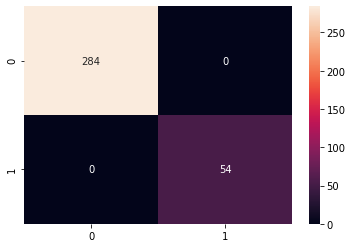

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True,fmt='g')

In [68]:
# Accuracy
classification.score(X_test, y_test)

1.0

In [66]:
# Accuracy
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predictions)))


Accuracy: 1.00



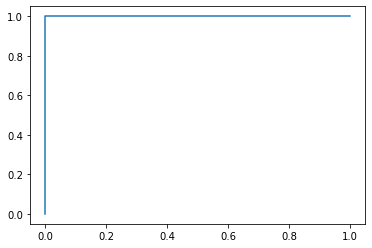

In [67]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)